# Wieloboki Voronoi'a

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.tests.test1 import Test
from bitalg.visualizer.main import Visualizer

In [3]:
def draw_points(points):
    vis = Visualizer()
    vis.add_point(points, s=2, color='green')
    vis.show()

In [4]:
def draw_tri(triangleList):
    vis = Visualizer()
    points = set()
    sides = set()
    for triangle in triangleList:
        a = (triangle.a.x, triangle.a.y)
        b = (triangle.b.x, triangle.b.y)
        c = (triangle.c.x, triangle.c.y)
        points.add(a)
        points.add(b)
        points.add(c)
        sides.add((a, b))
        sides.add((b, c))
        sides.add((c, a))
    

    vis.add_point(list(points))
    vis.add_line_segment(list(sides), color='red')
    vis.show()

In [5]:
def generate_uniform_points(left, right, n = 10 ** 5):
    tab =[]
    for _ in range(n):
        x = np.random.uniform(left, right)
        y = np.random.uniform(left, right)
        tab.append((x, y))
    return tab

**Funkcje pomocnicze**

In [136]:
# parametr epsilon
eps = 10**-8
def orient(a, b, c):
    return (b.x-a.x)*(c.y-b.y) - (b.y-a.y)*(c.x-b.x)

def collinear(x1, y1, x2, y2, x3, y3):
    a = x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)
    if abs(a)<eps: return True
    return False

def lineFromPoints(P, Q, a, b, c):
    a = Q[1] - P[1]
    b = P[0] - Q[0]
    c = a * (P[0]) + b * (P[1])
    return a, b, c
 
def perpenBisectorFromLine(P, Q, a, b, c):
    mid_point = [0, 0]
    mid_point[0] = (P[0] + Q[0]) / 2
    mid_point[1] = (P[1] + Q[1]) / 2
    c = (-b * (mid_point[0]) + a * (mid_point[1]))
    temp = a
    a = -b
    b = temp
    return a, b, c
 
def LineInterX(a1, b1, c1, a2, b2, c2):
    determ = a1 * b2 - a2 * b1
    x = (b2 * c1 - b1 * c2)
    x /= determ
    return x
 

def LineInterY(a1, b1, c1, a2, b2, c2):
    determ = a1 * b2 - a2 * b1
    y = (a1 * c2 - a2 * c1)
    y /= determ
    return y
 
def findPosition(P, Q, R, D):
    if collinear(P[0],P[1],Q[0],Q[1],R[0],R[1]): return False
    r = [0, 0]
    a, b, c = lineFromPoints(P, Q, 0, 0, 0)
    e, f, g = lineFromPoints(Q, R, 0, 0, 0)
    a, b, c = perpenBisectorFromLine(P, Q, 
                                     a, b, c)
    e, f, g = perpenBisectorFromLine(Q, R, 
                                     e, f, g)
    r[0] = LineInterX(a, b, c, e, f, g)
    r[1] = LineInterY(a, b, c, e, f, g)
    q = ((r[0] - P[0]) *
         (r[0] - P[0]) +
         (r[1] - P[1]) *
         (r[1] - P[1]))
    dis = ((r[0] - D[0]) *
           (r[0] - D[0]) +
           (r[1] - D[1]) *
           (r[1] - D[1]))
    # if (dis < q):
    #     print("Point (", D[0], ",", D[1],
    #           ") is inside the circumcircle")
    # elif (dis == q):
    #     print("Point (", D[0], ",", D[1], 
    #           ") lies on the circumcircle")
    # else:
    #     print("Point (", D[0], ",", D[1], 
    #           ") lies outside the circumcircle")
    if dis<=q: return True
    return False

**Klasy**

In [193]:
# parametr epsilon
eps = 10**-12

class Point():
    def __init__(self,point):
        self.x = point[0]
        self.y = point[1]

    def __eq__(self, other):
        return abs(self.x-other.x)<eps and abs(self.y-other.y)<eps
    
    def __hash__(self):
        return hash((self.x, self.y))
    
    def toCart(self):
        return (self.x, self.y)
    
class Edge():
    def __init__(self, PointA, PointB):
        self.A = PointA
        self.B = PointB
        self.triangleList = set()

    def __eq__(self, other):
        return (self.A==other.A and self.B==other.B) or (self.A==other.B and self.B==other.A)
    
    def __hash__(self):
        return hash(Point((self.A.x+self.B.x, self.A.y+self.B.y)))
    
    def toCart(self):
        return ((self.A.x, self.A.y), (self.B.x, self.B.y))


class Triangle():
    def __init__(self,a,b,c):
        self.a = a
        self.b = b
        self.c = c
        self.isCorrect = True

    def __eq__(self, other):
        return self.a==other.a and self.b==other.b and self.c==other.c
    
    def __hash__(self):
        return hash((self.a, self.b, self.c))
    
    def containsPoint(self, point):
        return self.a==point or self.b==point or self.c==point
    
    def circumcircleContainsPoint(self, point):
        P = self.a.toCart()
        Q = self.b.toCart()
        R = self.c.toCart()
        D = point.toCart()
        return findPosition(P, Q, R, D)
    
    def sharesEdge(self, edge):
        x = edge.A
        y = edge.B
        trianglePoints = [self.a, self.b, self.c]
        return x in trianglePoints and y in trianglePoints

**Algorytmy**

In [194]:
# https://www.baeldung.com/cs/voronoi-diagram
def Bowyer_Watson(points):
    lowerX = points[0][0]
    lowerY = points[0][1]
    upperX = points[0][0]
    upperY = points[0][1]
    pointList = []
    for point in points:
        newPoint = Point(point)
        pointList.append(newPoint)
        if point[0]<lowerX: lowerX = point[0]
        if point[1]<lowerY: lowerY = point[1]
        if point[0]>upperX: upperX = point[0]
        if point[1]>upperY: upperY = point[1]


    vis = Visualizer()
    triangleList = []
    # Prostokąt
    lowerX-=100
    lowerY-=100
    upperX+=100
    upperY+=100
    superA = Point((lowerX, lowerY))
    superB = Point((lowerX, upperY))
    superC = Point((upperX, upperY))
    superD = Point((upperX, lowerY))
    vis.add_point([superA.toCart(),superB.toCart(),superC.toCart(),superD.toCart()],color='green')
    # Dwa trójkąty
    superTriangle1 = Triangle(superA, superB, superC)
    superTriangle2 = Triangle(superC, superD, superA)
    triangleList.append(superTriangle1)
    triangleList.append(superTriangle2)

    for point in pointList:
        vis.add_point(point.toCart(),color='blue')
        # klucz: krawedz, wartość: zbiór trójkątów
        edgeList = {}
        to_delete = []

        to_draw = []
        for triangle in triangleList:
            a = triangle.a
            b = triangle.b
            c = triangle.c
            to_draw+=[(a.toCart(), b.toCart()), (b.toCart(), c.toCart()), (c.toCart(), a.toCart())]
        to_delete.append(vis.add_line_segment(to_draw,color='black')) 

        to_draw = []
        for triangle in triangleList:
            if triangle.circumcircleContainsPoint(point):
                triangle.isCorrect=False
                a = triangle.a
                b = triangle.b
                c = triangle.c
                edgeAB = Edge(a, b)
                edgeBC = Edge(b, c)
                edgeCA = Edge(c, a)
                if edgeAB in edgeList.keys():
                    edgeList[edgeAB].add(triangle)
                else:
                    edgeList[edgeAB] = set()
                    edgeList[edgeAB].add(triangle)
                if edgeBC in edgeList.keys():
                    edgeList[edgeBC].add(triangle)
                else:
                    edgeList[edgeBC] = set()
                    edgeList[edgeBC].add(triangle)
                if edgeCA in edgeList.keys():
                    edgeList[edgeCA].add(triangle)
                else:
                    edgeList[edgeCA] = set()
                    edgeList[edgeCA].add(triangle)
                to_draw+=[edgeAB.toCart(), edgeBC.toCart(), edgeCA.toCart()]
        ls = vis.add_line_segment(to_draw, color='red')
        vis.remove_figure(ls)
        newTriangleList = []
        for triangle in triangleList:
            if triangle.isCorrect==True: newTriangleList.append(triangle)

        triangleList = newTriangleList
        #print(len(triangleList))    
        

            
        # Usunięcie krawędzi
        newEdgeList = dict(edgeList)
        for edge in edgeList.keys():
            # print(edge)
            # print(edgeList[edge])
            # print('!')
            if len(edgeList[edge])>1:
                newEdgeList.pop(edge)

        #ls = vis.add_line_segment(newEdgeList.keys(), color='purple')

        for edge in newEdgeList:
            triangle = Triangle(edge.A, edge.B, point)
            triangleList.append(triangle)

        for fig in to_delete:
            vis.remove_figure(fig)

    finalTriangleList = list(triangleList)
    for triangle in triangleList:
        if triangle.containsPoint(superA) or triangle.containsPoint(superB) or triangle.containsPoint(superC) or triangle.containsPoint(superD):
            finalTriangleList.remove(triangle)
    
    
    
    return vis, finalTriangleList

**Testy**

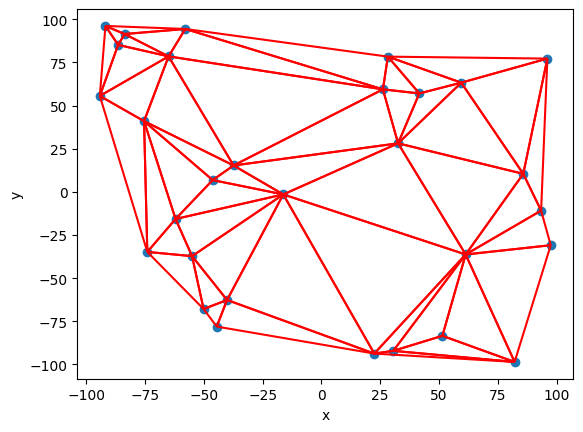

In [198]:
# nie działa
randomPoints = generate_uniform_points(-100, 100, 30)
vis, triangulation = Bowyer_Watson(randomPoints)
#print(triangulation)
draw_tri(triangulation)
#vis.show_gif(interval = 1000)

**Główny algorytm**


In [10]:
def Voronoi(points):
    '''
    points = [(x1, y1), (x2, y2), ...]
    '''
    # ...
    pass



**Testy algorytmu**